# Optimization of Product Merchandising and Sales Enhancement through Recommendation Systems Using Collaborative Filtering
Name: Md Tauhidul Islam

ID: a1895813

### 1. Importing required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix

### 2. Loading the traning data

In [2]:
# Load the training dataset
data = pd.read_csv('./data/basket_data_by_date_train.csv')

# Display the first few rows to understand its structure
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [3]:
# Display basic info
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


(40000, 7)

In [4]:
# Summary statistics for numeric columns
print(data.describe())

              BillNo      Quantity         Price    CustomerID          cost
count   40000.000000  40000.000000  40000.000000  40000.000000  40000.000000
mean   540254.879225      3.487700      3.732165  15577.606525     11.097411
std      2380.444952      2.611766      5.711630   1730.347123     13.298301
min    536365.000000      1.000000      0.100000  12347.000000      0.140000
25%    538093.000000      1.000000      1.650000  14224.000000      3.300000
50%    540373.000000      2.000000      2.950000  15570.000000      7.950000
75%    542360.000000      6.000000      4.650000  17220.000000     15.800000
max    544398.000000     10.000000    295.000000  18283.000000    527.700000


### 3. Data pre-processing

* 3.1 Convert 'Date' to datetime

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850,15.30


* 3.2 Finding and removing duplicate data

In [7]:
data.duplicated().sum()

797

In [8]:
#Let's remove the duplicate data
data = data.drop_duplicates()

* 3.3 Removing sparse data (users or items with very few interactions) 

In [9]:
# Let's check shape of the original data
print("Initial data shape:", data.shape)

# Calculating the number of interactions per user and per item
user_interactions = data['CustomerID'].value_counts()
item_interactions = data['Itemname'].value_counts()

# Defining a threshold for minimum interactions
min_user_interactions = 5
min_item_interactions = 10

# Filtering users and items that have fewer than the minimum interactions
users_to_keep = user_interactions[user_interactions >= min_user_interactions].index
items_to_keep = item_interactions[item_interactions >= min_item_interactions].index

# Filtering the data based on users and items to keep
filtered_data = data[data['CustomerID'].isin(users_to_keep) & data['Itemname'].isin(items_to_keep)]

# Overview of the filtered data
print()
print("Filtered data shape:", filtered_data.shape)

Initial data shape: (39203, 7)

Filtered data shape: (33502, 7)


In [10]:
# Now let's check the basic info again
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33502 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BillNo      33502 non-null  int64         
 1   Itemname    33502 non-null  object        
 2   Quantity    33502 non-null  int64         
 3   Date        33502 non-null  datetime64[ns]
 4   Price       33502 non-null  float64       
 5   CustomerID  33502 non-null  int64         
 6   cost        33502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 2.0+ MB


### 4. Data Visualisation

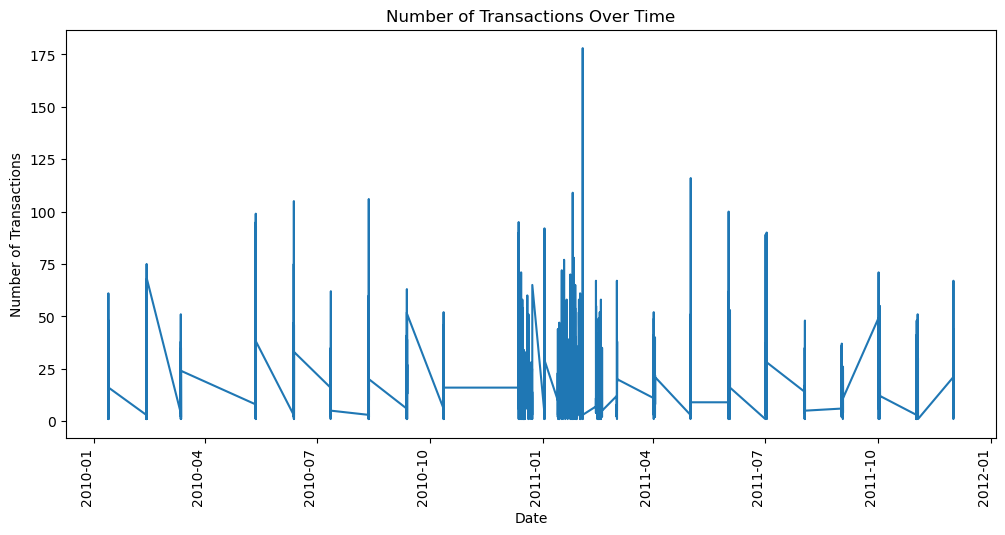

In [11]:
# Transactions over time
transactions_over_time = filtered_data['Date'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
transactions_over_time.plot(kind='line')
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Number of Transactions')
plt.show()

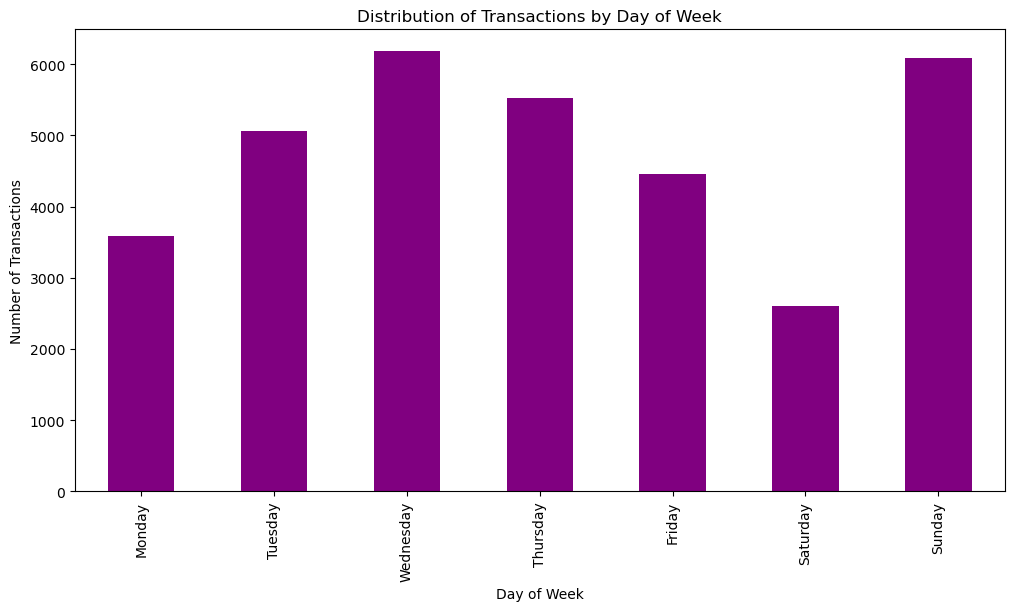

In [12]:
# Plot transactions by day of week
filtered_data['DayOfWeek'] = filtered_data['Date'].dt.day_name() 
# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day_name.html

day_of_week_counts = filtered_data['DayOfWeek'].value_counts()[
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
plt.figure(figsize=(12, 6))
day_of_week_counts.plot(kind='bar', color='purple')
plt.title('Distribution of Transactions by Day of Week')
plt.xlabel('Day of Week')
plt.xticks(rotation=90)
plt.ylabel('Number of Transactions')
plt.show()



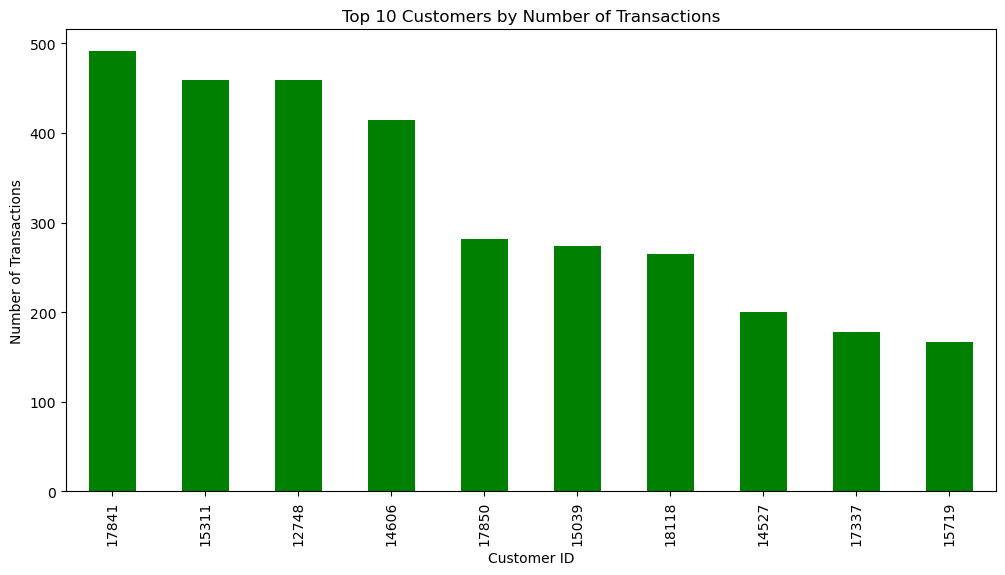

In [13]:
# Top 10 customers by number of transactions
top_customers = filtered_data['CustomerID'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_customers.plot(kind='bar', color='green')
plt.title('Top 10 Customers by Number of Transactions')
plt.xlabel('Customer ID')
plt.ylabel('Number of Transactions')
plt.show()

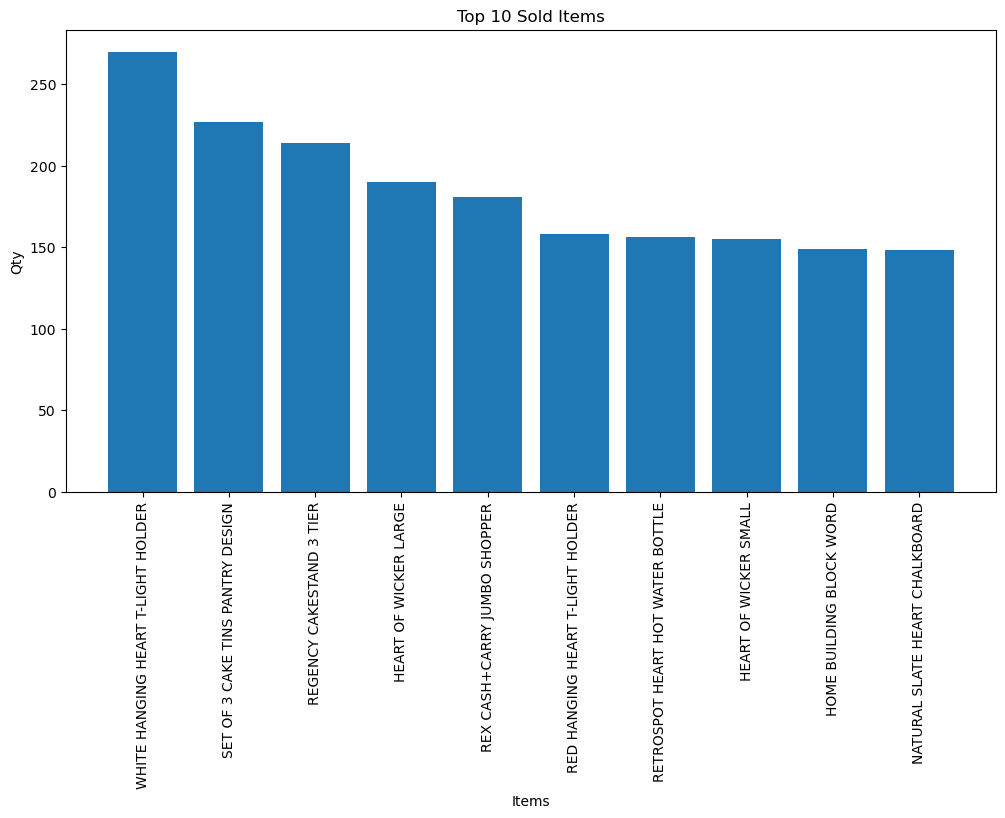

In [14]:
# Top 10 items sold
item_distribution = filtered_data.groupby (
    by = 'Itemname').size().reset_index(
    name = 'Frequency').sort_values(
    by = 'Frequency', ascending = False).head(10)
# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

bars = item_distribution['Itemname']
height = item_distribution['Frequency']
x_positions = np.arange(len(bars))
# Reference: https://numpy.org/doc/stable/reference/generated/numpy.arange.html

plt.figure(figsize = (12, 6))
plt.bar(x_positions, height)
plt.title("Top 10 Sold Items")
plt.xlabel("Items")
plt.ylabel("Qty")
plt.xticks(x_positions, bars, rotation='vertical')
plt.show()

### 5. Recommendation system

* 4.1 Recommendation by users

In [15]:
# Representing the user preferences as a matrix (User-Item)
train_user_item_matrix = filtered_data.pivot_table(
    index='CustomerID', columns='Itemname', values='Quantity', aggfunc='sum', fill_value=0)
# Reference: Wrokshop, https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

# Converting to sparse matrix format for more efficient computations
sparse_user_item = csr_matrix(train_user_item_matrix.values)
# Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

# Computing Item-Item Similarity
# Since we're dealing with a sparse matrix, transposing it will give us item-user matrix for computing cosine similarity
item_user_matrix = sparse_user_item.T  # Transposing to get item-user matrix
item_similarity = cosine_similarity(item_user_matrix) # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

# Converting item similarity matrix to DataFrame for easier handling
item_similarity_df = pd.DataFrame(item_similarity, index=train_user_item_matrix.columns, columns=train_user_item_matrix.columns)

# Generating Recommendations
def recommend_items_for_customer(user_id, top_n=5):
    # Geting the items already bought by the user
    purchased_items = train_user_item_matrix.loc[user_id]
    purchased_items = purchased_items[purchased_items > 0].index
    
    # Calculating scores for items based on item-item similarities
    scores = item_similarity_df[purchased_items].sum(axis=1)
    
    # Removing already purchased items from recommendation
    scores = scores.drop(purchased_items)
    
    # Geting top N items with the highest scores
    top_items = scores.nlargest(top_n).index.tolist()
    return top_items

    #Implemented based on learning from myuni workshop 10 

In [16]:
# Example usage - Let's see the recommendation for our top 5 customers
user_ids_to_check = [17841, 15311, 12748, 17850, 15039]
for user_id in user_ids_to_check:
    recommended_items = recommend_items_for_customer(user_id, 5)
    print(f"Recommended top 5 items for customer {user_id} are:\n{recommended_items}\n")

Recommended top 5 items for customer 17841 are:
['EDWARDIAN PARASOL NATURAL', 'SET OF 3 HEART COOKIE CUTTERS', 'HOME BUILDING BLOCK WORD', 'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG  BLACK SKULL.']

Recommended top 5 items for customer 15311 are:
['WHITE HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT', 'SET OF 72 PINK HEART PAPER DOILIES', 'HEART OF WICKER SMALL', 'SET OF 3 CAKE TINS PANTRY DESIGN']

Recommended top 5 items for customer 12748 are:
['SET OF 3 HEART COOKIE CUTTERS', 'PACK OF 72 RETROSPOT CAKE CASES', 'HAND OVER THE CHOCOLATE   SIGN', 'RED HANGING HEART T-LIGHT HOLDER', 'BLUE SPOT CERAMIC DRAWER KNOB']

Recommended top 5 items for customer 17850 are:
['EDWARDIAN PARASOL NATURAL', 'WOOD BLACK BOARD ANT WHITE FINISH', 'ENGLISH ROSE HOT WATER BOTTLE', 'RETROSPOT HEART HOT WATER BOTTLE', 'CHOCOLATE HOT WATER BOTTLE']

Recommended top 5 items for customer 15039 are:
['SET OF 3 HEART COOKIE CUTTERS', 'SET/10 RED POLKADOT PARTY CANDLES', 'VICTORIAN SEWING BOX LARGE', 'WOOD

* 4.2 Recommendation by items

In [17]:
def recommend_items_for_item(item_name, top_n=5):
    # Geting top N similar items to the item_name
    top_similar_items = item_similarity_df[item_name].sort_values(ascending=False)[1:top_n+1].reset_index()
    top_similar_items.columns = ['Itemname', 'Similarity']
    return top_similar_items

# Example usage: Let's see what our it recommends with the most popular item
recommended_items_item = recommend_items_for_item('WHITE HANGING HEART T-LIGHT HOLDER', 5)
print("Top 5 recomanded items for WHITE HANGING HEART T-LIGHT HOLDER are:")
recommended_items_item


Top 5 recomanded items for WHITE HANGING HEART T-LIGHT HOLDER are:


,Itemname,Similarity
0,WOODEN PICTURE FRAME WHITE FINISH,0.691606
1,HAND WARMER UNION JACK,0.679674
2,GLASS STAR FROSTED T-LIGHT HOLDER,0.679450
3,RED WOOLLY HOTTIE WHITE HEART.,0.674411
4,KNITTED UNION FLAG HOT WATER BOTTLE,0.671572


### 6. Testing the recommendation system

In [18]:
# Assuming you have a test dataset with actual ratings
test_data = pd.read_csv('./data/basket_data_by_date_test.csv')  # Update the path
test_data.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [19]:
# Creating user-item matrix from test data
test_user_item_matrix = test_data.pivot_table(
    index='CustomerID', columns='Itemname', values='Quantity', aggfunc='sum', fill_value=0)

def test_recommendation_system(test_user_item_matrix, train_user_item_matrix, recommend_items_for_customer, top_n=5):
    user_ids = test_user_item_matrix.index # Extracting user IDs from the test user-item matrix
    users_with_recommedation = 0 # Initializing a counter for users with recommendations
    
    # Empty lists for evaluation metrics and successful examples
    rmse_scores = []
    precision_list = []
    recall_list = []
    successfull_examples = []
    

    for user_id in user_ids:
        # Checking if user_id exists in the training matrix to avoid KeyError
        if user_id in train_user_item_matrix.index:
            # Geting actual items from the test set
            actual_items = test_user_item_matrix.loc[user_id]
            actual_items = set(actual_items[actual_items > 0].index)
            
            # Geting predicted items from the recommendation function
            pred_items = recommend_items_for_customer(user_id, top_n)
            
            # Incrementing the counter if recommendations are available for the user
            if pred_items:
                users_with_recommedation += 1
                
            # Finding the intersection of actual and predicted items
            matching_pair = actual_items.intersection(set(pred_items))
            if matching_pair and len(successfull_examples) < top_n: 
                # only storing top_n items: preventing storing an excessive number of examples
                successfull_examples.append((user_id, list(matching_pair)))
            
            # Creating actual and predicted ratings Series for MSE calculation
            actual_score = pd.Series(1, index=actual_items)
            pred_score = pd.Series(1, index=pred_items)
            
            # Combining actual and predicted items to ensure alignment for MSE calculation
            comb_items = actual_score.index.union(pred_score.index)
            actual_score = actual_score.reindex(comb_items, fill_value=0)
            pred_score = pred_score.reindex(comb_items, fill_value=0)

            # Calculating RMSE
            rmse = sqrt(mean_squared_error(actual_score, pred_score))
            rmse_scores.append(rmse)

            # Calculating precision and recall
            precision = len(matching_pair) / len(pred_items)
            recall = len(matching_pair) / len(actual_items)
            precision_list.append(precision)
            recall_list.append(recall)
        else:
            pass
            
  
    return rmse_scores, precision_list, recall_list, successfull_examples, users_with_recommedation



In [20]:
# Example Usage
rmse_scores, precision_list, recall_list, successfull_examples, users_with_recommedation = test_recommendation_system(
    test_user_item_matrix, train_user_item_matrix, recommend_items_for_customer)


print("Five successfull purchase as per the recommendation are as follows:\n")
for example in successfull_examples:
    user_id, matched_items = example
    print(f"User ID: {user_id} was successfully recommended and purchased: {matched_items}\n")

Five successfull purchase as per the recommendation are as follows:

User ID: 12423.0 was successfully recommended and purchased: ['RED RETROSPOT CHARLOTTE BAG']

User ID: 12528.0 was successfully recommended and purchased: ['SET OF 3 CAKE TINS PANTRY DESIGN']

User ID: 12553.0 was successfully recommended and purchased: ['STRAWBERRY LUNCH BOX WITH CUTLERY']

User ID: 12728.0 was successfully recommended and purchased: ["POPPY'S PLAYHOUSE BATHROOM", "POPPY'S PLAYHOUSE KITCHEN"]

User ID: 12748.0 was successfully recommended and purchased: ['HAND OVER THE CHOCOLATE   SIGN']



Let's check what we recommended the above users

In [21]:
user_ids_to_check = [12423.0 , 12528.0 , 12553.0 , 12728.0 , 12748.0 ]
for user_id in user_ids_to_check:
    recommended_items = recommend_items_for_customer(user_id, 5)
    print(f"Recommended top 5 items for customer {user_id} are:\n{recommended_items}\n")

Recommended top 5 items for customer 12423.0 are:
['RED RETROSPOT CHARLOTTE BAG', 'WOODLAND CHARLOTTE BAG', 'CHARLOTTE BAG SUKI DESIGN', 'CHARLOTTE BAG PINK POLKADOT', 'LOVE BUILDING BLOCK WORD']

Recommended top 5 items for customer 12528.0 are:
['CERAMIC CAKE STAND + HANGING CAKES', 'SET OF 3 CAKE TINS PANTRY DESIGN', 'SET OF 4 ENGLISH ROSE PLACEMATS', 'RECIPE BOX PANTRY YELLOW DESIGN', 'APPLE BATH SPONGE']

Recommended top 5 items for customer 12553.0 are:
["POPPY'S PLAYHOUSE LIVINGROOM", 'RED 3 PIECE RETROSPOT CUTLERY SET', 'STRAWBERRY LUNCH BOX WITH CUTLERY', 'GREEN 3 PIECE POLKADOT CUTLERY SET', 'JUMBO BAG STRAWBERRY']

Recommended top 5 items for customer 12728.0 are:
["POPPY'S PLAYHOUSE KITCHEN", "POPPY'S PLAYHOUSE BEDROOM", 'OFFICE MUG WARMER POLKADOT', "POPPY'S PLAYHOUSE BATHROOM", 'COOKING SET RETROSPOT']

Recommended top 5 items for customer 12748.0 are:
['SET OF 3 HEART COOKIE CUTTERS', 'PACK OF 72 RETROSPOT CAKE CASES', 'HAND OVER THE CHOCOLATE   SIGN', 'RED HANGING HEART

In [22]:
rmse_score = []
for rmse in rmse_scores:
    if rmse is not None:
        rmse_score.append(rmse)
avg_rmse = sum(rmse_score) / len(rmse_score)

user_coverage = users_with_recommedation / len(test_user_item_matrix)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)

In [23]:
print(f"Average RMSE: {avg_rmse}")
print(f"User Coverage: {user_coverage}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")

Average RMSE: 0.9900950640987273
User Coverage: 0.4277456647398844
Average Precision: 0.0801801801801801
Average Recall: 0.029545167266316737


In [24]:
metrics = [user_coverage, avg_precision, avg_recall, avg_rmse]
metrics_labels = ['User Coverage', 'Average Precision', 'Average Recall', 'RMSE']

metrics_table = pd.DataFrame({
    'Metrics':metrics_labels,
    'Value': metrics
})

# Displaying the DataFrame as a table
metrics_table

,Metrics,Value
0,User Coverage,0.427746
1,Average Precision,0.080180
2,Average Recall,0.029545
3,RMSE,0.990095


### 7. Reference

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.day_name.html
    
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
    
https://numpy.org/doc/stable/reference/generated/numpy.arange.html

https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

Wrokshop for understanding the methods